In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import pickle


In [2]:
file_path = r'C:\Users\SAGNEEK SENGUPTA\Documents\Transformer fault\DGA_dataset.csv'  
df = pd.read_csv(file_path)

In [3]:
X = df.drop(columns=['Type', 'NM']) 
y = df['Type']

In [4]:
print("Class distribution before oversampling:\n", y.value_counts())

Class distribution before oversampling:
 Type
Arc discharge                         54
Spark discharge                       49
High-temperature overheating          38
Low-temperature overheating           19
Partial discharge                     16
Low/Middle-temperature overheating    16
Middle-temperature overheating         9
Name: count, dtype: int64


In [5]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

c:\Users\SAGNEEK SENGUPTA\Documents\Transformer fault\transformer\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\SAGNEEK SENGUPTA\Documents\Transformer fault\transformer\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [6]:
print("Class distribution after oversampling:\n", pd.Series(y_resampled).value_counts())

Class distribution after oversampling:
 Type
Partial discharge                     54
Spark discharge                       54
Arc discharge                         54
High-temperature overheating          54
Middle-temperature overheating        54
Low-temperature overheating           54
Low/Middle-temperature overheating    54
Name: count, dtype: int64


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [20]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
param_dist = {
    'n_estimators': [50 ,100, 200, 300, 400, 500, 1000],
    'max_depth': [None,5, 10, 20, 30, 50, 70],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]   
}

In [21]:
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=100,
    scoring='f1_macro',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 5, 10, 20, 30, 50,
                                                      70],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [50, 100, 200, 300, 400,
                                                         500, 1000]},
                   random_state=42, scoring='f1_macro', verbose=2)

In [22]:
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}


In [23]:
best_rf = random_search.best_estimator_
best_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=30,
                       min_samples_leaf=2, min_samples_split=5, n_estimators=50,
                       random_state=42)

In [24]:
y_pred = best_rf.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[ 6  2  0  0  0  0  2]
 [ 1  9  0  0  1  0  0]
 [ 0  0 10  1  0  0  0]
 [ 0  0  1  9  0  1  0]
 [ 0  0  1  1  9  0  0]
 [ 0  0  0  0  0 11  0]
 [ 2  0  0  0  0  0  9]]

Classification Report:
                                     precision    recall  f1-score   support

                     Arc discharge       0.67      0.60      0.63        10
      High-temperature overheating       0.82      0.82      0.82        11
       Low-temperature overheating       0.83      0.91      0.87        11
Low/Middle-temperature overheating       0.82      0.82      0.82        11
    Middle-temperature overheating       0.90      0.82      0.86        11
                 Partial discharge       0.92      1.00      0.96        11
                   Spark discharge       0.82      0.82      0.82        11

                          accuracy                           0.83        76
                         macro avg       0.82      0.83      0.82        76
                      wei

In [28]:
y_test_binary = (y_test == "Arc discharge").astype(int)
y_scores = best_rf.predict_proba(X_test)[:, best_rf.classes_ == "Arc discharge"].flatten()

In [29]:
precision, recall, thresholds = precision_recall_curve(y_test_binary, y_scores)
optimal_threshold = thresholds[np.argmax(precision + recall)]

In [31]:
for i, class_label in enumerate(best_rf.classes_):
    y_test_binary = (y_test == class_label).astype(int)
    y_scores = best_rf.predict_proba(X_test)[:, i]

    precision, recall, thresholds = precision_recall_curve(y_test_binary, y_scores)
    avg_precision = average_precision_score(y_test_binary, y_scores)

    print(f"Class: {class_label}, Average Precision: {avg_precision}")

Class: Arc discharge, Average Precision: 0.5907174185463658
Class: High-temperature overheating, Average Precision: 0.7415685324776233
Class: Low-temperature overheating, Average Precision: 0.986013986013986
Class: Low/Middle-temperature overheating, Average Precision: 0.9494949494949496
Class: Middle-temperature overheating, Average Precision: 0.9722550177095632
Class: Partial discharge, Average Precision: 0.9999999999999999
Class: Spark discharge, Average Precision: 0.8130526039616949


In [33]:
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold for 'Arc discharge': {optimal_threshold}")

Optimal Threshold for 'Arc discharge': 0.36364202359016784


In [37]:
importances = best_rf.feature_importances_
feature_names = X.columns

In [38]:
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

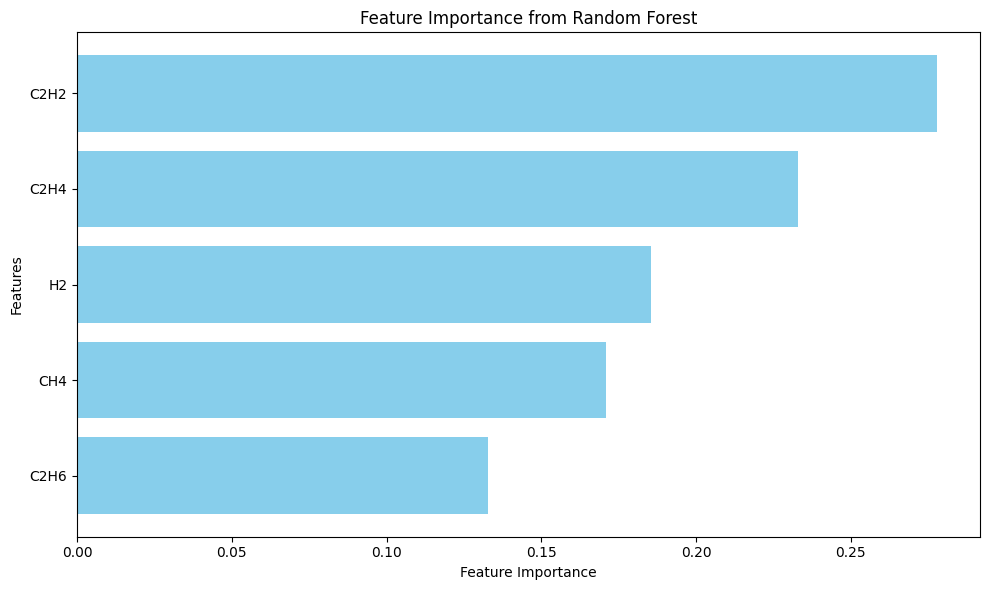

In [45]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()

### Observation

The horizontal bar chart illustrates the feature importance derived from the Random Forest model. We Observe:
1.  **C2H2** holds the highest importance, followed by **C2H4** and **H2**, indicating their strong influence on the model's decision-making process. 
2. Features like **CH4** and **C2H6** have comparatively lower importance, but still contribute to the overall prediction. 



In [46]:
model_path = "DGA_Fault.pkl"
with open(model_path, 'wb') as file:
    pickle.dump(best_rf, file)
print(f"Model saved to {model_path}")

Model saved to DGA_Fault.pkl
